In [75]:
import pandas as pd 
import numpy as np 
import datetime as dt
from datetime import timedelta
import os
import sys
import pyodbc
import time
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from sklearn import preprocessing
import math 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 


In [2]:
def datetime_range(start, end, delta):
    current = start
    if not isinstance(delta, timedelta):
        delta = timedelta(**delta)
    while current < end:
        yield current
        current += delta

# Bring in Punch In Data from HR 

In [3]:
punchTimesDF = pd.read_csv(r'/Users/sanjaygopinath/Documents/Data/foot_traffic_project/RetailDailyPunches.csv', index_col=None)

punchTimesDF.rename(columns= {'In Punch Date':'In_Date', 'In Punch Time':'In_Time', 'Out Punch Date':'Out_Date',
                                  'Out Punch Time':'Out_Time','Store Number':'Store_Number', 'EE Number':'EE_Number'}, inplace=True)
title_dictionary = {'Key Holder full time':'Key Holder', 'Key Holder Part Time':'Key Holder', 'Key Holder Part time':'Key Holder',
            'Key Holder part time':'Key Holder', 'Key Holder Full Time':'Key Holder', 'Sr. Sales Associate':'Sales Associate'}

punchTimesDF.replace({"Title": title_dictionary}, inplace=True)


#Combining date and hours into a single colummn 
punchTimesDF['in'] = punchTimesDF['In_Date'] + ' ' + punchTimesDF['In_Time']

punchTimesDF['out'] = punchTimesDF['Out_Date'] + ' ' + punchTimesDF['Out_Time']

#Converting to datetime 

punchTimesDF['in'] = pd.to_datetime(punchTimesDF['in'])
punchTimesDF['out'] = pd.to_datetime(punchTimesDF['out'])


#calculating the hours worked from our raw times 
punchTimesDF['raw_hours'] = punchTimesDF['out'] - punchTimesDF['in']

#ROunding the in and out dates to the nearest half hour 




punchTimesDF['rounded_in'] = punchTimesDF['in'].dt.round('15min')

punchTimesDF['rounded_out'] = punchTimesDF['out'].dt.round('15min')





#calcuatling the hours worked from our rounded times

punchTimesDF['rounded_hours'] = punchTimesDF['rounded_out'] - punchTimesDF['rounded_in']



In [4]:
#This bit creates a very narrow, long dataframe that should have every store number, every hour and every EE number
# that is in the punch data, we then use a groupby to get the number of unique names for each store hour, so that we know 
#the number of employees in the store at anyone time 


emptyFrame = pd.DataFrame()

for i in punchTimesDF.index:
    x = ([datetime_range(punchTimesDF['rounded_in'][i], punchTimesDF['rounded_out'][i], {'minutes':15})])
    tFrame= pd.DataFrame(x)
    tFrame = tFrame.transpose()
    tFrame.rename(columns={0:'hours'}, inplace=True)
    tFrame['EE_Number'] = punchTimesDF['EE_Number'][i]
    tFrame['Store_Number'] = punchTimesDF['Store_Number'][i]
    emptyFrame = emptyFrame.append(tFrame, )
    
grouped_emp_frame = emptyFrame['EE_Number'].groupby([emptyFrame['hours'], emptyFrame['Store_Number']]).nunique()
grouped_emp_frame = grouped_emp_frame.reset_index()
grouped_emp_frame.rename(columns={'EE_Number':'In_Store'}, inplace=True)

# We pull in transaction data from our sql server

In [5]:
def Generic_QL_Query(query, UID, password ):

#Establish our connection to the server 
    conn_string = 'DRIVER=/usr/local/lib/libtdsodbc.so;SERVER=wnj-datasizesql;PORT=1433;DATABASE=Data Analytics;UID={};PWD={}'.format(UID,password)
    conn = pyodbc.connect(conn_string)
    
#Run our sql query

    
    start_time = time.time()

    trFrame = pd.read_sql_query(query, conn)

    conn.close()

    end_time = time.time()

    run_time = (end_time-start_time)/60

    print(run_time)
    return(trFrame)

In [ ]:
#The above is a half hourly summary of transactions for each store, below is a fifteen minute summary of transactions 
#for each store

In [144]:
query = """  select
       a.transaction_datetime, a.store_no,
       count(a.transaction_id) as transaction_count,
       SUM(a.total_amount) as total_amount,
       SUM(a.total_amount)/count(a.transaction_id) as AOV5min
  FROM (
         SELECT transaction_id, store_no,
                CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 96.0, 0, 1) /
                                       96.0)                 as transaction_datetime,
                SUM(gross_line_amount - pos_discount_amount) as total_amount
         FROM transaction_detail_entry_datetime
         where
           sku_id is not null
          and store_no in
          (28,  229,  397,   18,   30,   40,   47,   67,   69,   71,  120,
        136,  144,  147,  167,  187,  192,  201,  210,  214,  242,  275,
        297,  301,  309,  312,  314,  315,  319,  323,  342,  350,  355,
        357,  359,  388,  442,  450,  452,  453,  456,  466,  488,  511,
        517,  528,  536,  554,  559,  571,  583,  597,  598,  607,  612,
        616,  617,  623,  633,  679,  689,  703,  710,  712,  763,  777,
        784,  823,  828,  833,  861, 1003, 1013,   60,  189,  444,  507,
        573,  868)
         GROUP BY transaction_id, store_no,
         CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 96.0, 0, 1) / 96.0)
       )a
GROUP BY a.store_no, a.transaction_datetime
ORDER BY  a.store_no,a.transaction_datetime;"""



In [145]:
storeSales_frame = Generic_QL_Query(query,'Dhananjay.Kumar','password1!')

0.059511466821034746


In [8]:
#Dhananjay's code above rounds every single transaction down to the nearest 15 minute increment
#but because of the way we are joining our different data frames, we need everything to be rounded up 
#
#In other words, the 8:15 row should reflect all transactions that occurred between 8 and 8:15
#We are joining our labor hours and transaction data on 

storeSales_frame['transaction_datetime'] = storeSales_frame['transaction_datetime'] +pd.Timedelta('15 minute')

# Bring in Foot Traffic data

In [32]:
query = """SELECT  *
    FROM daily_stores_traffic_min """



In [33]:
traffic_frame = Generic_QL_Query(query,'Dhananjay.Kumar','password1!')
#Since we are using the end of the time period, we need them to be round numbers, at the moment, they are inclusive 
#2019-01-02 08:00:00	2019-01-02 08:14:00
#We need to change that to 
# 2019-01-02 08:00:00	2019-01-02 08:15:00
traffic_frame['traffic_until'] = traffic_frame['traffic_until'] +pd.Timedelta('1 minute')
traffic_frame['day'] = traffic_frame.traffic_from.dt.dayofweek
traffic_frame['weekend'] = traffic_frame['day'].isin([5,6])

0.04551411469777425


In [12]:
#add a weekend flag
traffic_frame['weekend'] = traffic_frame['day'].isin([5,6])

# Let's combine all 3 data sets 

In [34]:
final_frame = pd.merge(traffic_frame, grouped_emp_frame,  how='left', left_on=['traffic_until','store_no'], right_on = ['hours','Store_Number'])

In [35]:
final_frame = pd.merge(final_frame, storeSales_frame,  how='left', left_on=['traffic_until','store_no'], right_on = ['transaction_datetime','store_no'])

In [36]:
print("There are {} perecentage of 15 minute increments that dont have any transactions".format(np.sum(final_frame.transaction_datetime.isna())/final_frame.shape[0]))

There are 0.1677764871143768 perecentage of 15 minute increments that dont have any transactions


In [38]:
final_frame.set_index('traffic_until', inplace=True)

In [39]:
#Fill in the Nans with zero (since no records means no transactions)
for i in ['transaction_count','total_amount','AOV5min']:
    final_frame[i].fillna(0, inplace=True)

final_frame['conv_rate'] = final_frame['transaction_count']/final_frame['traffic_out'] 
final_frame['conv_rate'].fillna(0, inplace=True)
final_frame['conv_rate'].replace(float('Inf'), 1, inplace=True)

final_frame['In_Store'].fillna(1, inplace=True)


In [219]:
#Createa a customer to employee ratio 
final_frame['cust_to_emp'] = final_frame.traffic_out/final_frame.In_Store

# Analysis

In [52]:
#Let's subset our data to just the stores we need to analayze now (for the time being (Mar 14), we are 
# focused on just Boston Stores)
test_districts_lists = pd.read_csv(r'/Users/sanjaygopinath/Documents/Data/foot_traffic_project/Received/Test_District_List.csv', header=0)

In [69]:
#Here we are subsetting to just district 108 (New England)
final_frame = final_frame[final_frame.store_no.isin(test_districts_lists[test_districts_lists.District == 108]['Store_no'])]

In [72]:
#normalize the number of employees in store by store and day and hour (x - x.mean)/x.std_dev
final_frame['In_Store_Normalized'] = final_frame['In_Store'].groupby([final_frame['store_no'],final_frame['day'],final_frame.traffic_until.dt.hour]).transform(lambda x: (x - x.mean()) / x.std())

In [230]:
#Is the ratio of customer to employees related to the conversion rate? 

np.corrcoef(final_frame.cust_to_emp, final_frame.total_amount)

array([[1.        , 0.59292659],
       [0.59292659, 1.        ]])

In [44]:
final_frame.reset_index(inplace=True)

In [45]:
#Get store, day, hour rankings 

final_frame['In_Store_Normalized'] = final_frame['In_Store'].groupby([final_frame['store_no'],final_frame['day'],final_frame['traffic_until'].dt.hour]).rank()

In [46]:
#Get store, day, hour rankings converted to percent
final_frame['In_Store_Normalized'] = final_frame['In_Store'].groupby([final_frame['store_no'],final_frame['traffic_until'].dt.hour]).rank(pct=True)

In [47]:
tempFrame = final_frame[final_frame['store_no']==60] #subset by store 
tempFrame = final_frame[final_frame['day']==5] #subset by day 
tempFrame = final_frame[final_frame.traffic_until.dt.hour.isin([10])] #subset by hour

In [48]:
x = tempFrame['total_amount'].groupby([tempFrame['In_Store'],tempFrame['traffic_out'], tempFrame['Store_Number'] ]).agg({'sum':'sum', 'count':'count'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [76]:
#Create a df correlating the total amount of sales against the number of people in store (or some other variable)
results_frame = pd.DataFrame()
for i in list(final_frame.store_no.unique()):
    temp_results_frame = pd.DataFrame(columns=['store', 'r_squared', 'observations'], index=[0])
    tempFrame = final_frame[final_frame['store_no']==i] #subset by day 
    tempFrame = tempFrame[tempFrame['weekend']==True]
    
    y = tempFrame["total_amount"]
    X = tempFrame['In_Store']
    #y = tempFrame["traffic_out"]

    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    
    temp_results_frame['store'] = i 
    temp_results_frame['r_squared'] = model.rsquared
    temp_results_frame['observations'] = model.nobs
    temp_results_frame['cor_ft_instore'] =  np.corrcoef(tempFrame['traffic_out'], tempFrame['In_Store'])[1][0]
    #print(temp_results_frame, i, model.rsquared)
    
    results_frame = results_frame.append(temp_results_frame, ignore_index=True)

In [80]:
results_frame

,store,r_squared,observations,cor_ft_instore
0,67,0.563233,484.0,0.027028
1,71,0.445994,484.0,-0.002420
2,342,0.552872,460.0,0.206842
3,456,0.563143,484.0,0.148436
4,536,0.408642,484.0,0.000726
5,583,0.524516,484.0,0.124701
6,689,0.388019,484.0,0.159818
7,763,0.409888,484.0,0.068902
8,828,0.406172,484.0,0.005383
9,833,0.312038,484.0,0.015030


Text(0.5,1,'Histogram of R-Squared of Regressions of $ to Employees In Store')

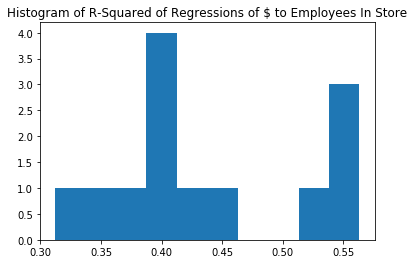

In [77]:
plt.hist(results_frame['r_squared'])
plt.title('Histogram of R-Squared of Regressions of $ to Employees In Store')

Text(0.5,1,'Histogram of 15 Minute Customer to Employee Ratios Avergaged by Store and Day/Hour')

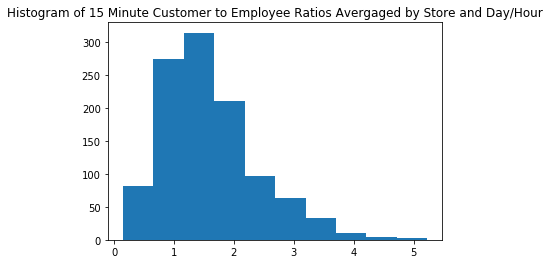

In [248]:
plt.hist((final_frame['cust_to_emp'].groupby([final_frame['store_no'], final_frame['traffic_from'].dt.dayofweek, final_frame['traffic_until'].dt.hour]).mean()))
plt.title('Histogram of 15 Minute Customer to Employee Ratios Avergaged by Store and Day/Hour')




In [91]:
#Let's look at foot traffic out for our stores by day and horu
tempFrame = final_frame['traffic_out'].groupby([final_frame['store_no'], final_frame['traffic_from'].dt.dayofweek, final_frame['traffic_until'].dt.hour]).mean()
tempFrame = tempFrame.to_frame()
tempFrame.reset_index(inplace=True)
#tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)

In [190]:
#Let's look at sales percentages 
tempFrame = final_frame['total_amount'].groupby([final_frame['store_no'], final_frame['traffic_from'].dt.dayofweek, final_frame['traffic_until'].dt.hour]).agg({'sales': 'sum'})
#tempFrame.reset_index(inplace=True)
# Change: groupby state_office and divide by sum
#tempFrame_pcts = tempFrame.groupby(level=0).apply(lambda x:
#                                                100 * x / float(x.sum()))
#tempFrame_pcts.reset_index(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [198]:
#Let's look at hourly sales for our stores  by day and hour 

#Let's look at foot traffic out for our stores by day and horu
tempFrame = final_frame['In_Store'].groupby([final_frame['store_no'], final_frame['traffic_from'].dt.dayofweek, final_frame['traffic_until'].dt.hour]).mean()
tempFrame = tempFrame.to_frame()
tempFrame.reset_index(inplace=True)
#tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)

In [225]:
#Let's look at hourly customer to employee ratios 

#Let's look at foot traffic out for our stores by day and horu
tempFrame = final_frame['cust_to_emp'].groupby([final_frame['store_no'], final_frame['traffic_from'].dt.dayofweek, final_frame['traffic_until'].dt.hour]).mean()
tempFrame = tempFrame.to_frame()
tempFrame.reset_index(inplace=True)
#tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)

In [ ]:
tempFrame = final_frame[final_frame['store_no']==28] #subset by day 
tempFrame = tempFrame[tempFrame['weekend']==True]
    

x = tempFrame['total_amount'].groupby([tempFrame['In_Store'], tempFrame['traffic_out']]).agg({'mean':'mean','count':'count'})

x.reset_index().to_clipboard()

tempFrame['In_Store'].groupby(tempFrame['traffic_until'].dt.hour)

plt.scatter(x=tempFrame['In_Store'].groupby(tempFrame['traffic_until'].dt.hour).mean(),
            y = tempFrame['total_amount'].groupby(tempFrame['traffic_until'].dt.hour).mean())
#plt.scatter(x=tempFrame['traffic_out'].groupby(tempFrame['traffic_until'].dt.hour).mean(),
 #           y = tempFrame['total_amount'].groupby(tempFrame['traffic_until'].dt.hour).mean())#

In [ ]:
plt.scatter(x=tempFrame['In_Store'].groupby(tempFrame['traffic_until'].dt.hour).mean(),
            y = tempFrame['total_amount'].groupby(tempFrame['traffic_until'].dt.hour).mean())
#plt.scatter(x=tempFrame['traffic_out'].groupby(tempFrame['traffic_until'].dt.hour).mean(),
 #           y = tempFrame['total_amount'].groupby(tempFrame['traffic_until'].dt.hour).mean())#

In [ ]:
plt.hist(tempFrame['traffic_out'].groupby([tempFrame['store_no'], tempFrame['traffic_until'].dt.day]).sum())

# Rolling Averages

In [51]:
# Lets get rolling 4 hour windows of average and total customers 

fourHourFrame =pd.DataFrame()
for i in list(final_frame['store_no'].unique()):
    print(i)
    tempFrame = final_frame[final_frame['store_no']==i]
    tempFrame.set_index('traffic_until', inplace=True)
    tempFrame.sort_index(inplace=True)
    #tempFrame.reset_index(inplace=True)
    tempFrame= tempFrame[['traffic_out', 'In_Store', 'conv_rate']]
    tempFrame = tempFrame.rolling('4H', min_periods=16).mean().dropna()
    newColumnName= 'store_'+str(i)
    tempFrame['store_no']=i
    fourHourFrame = fourHourFrame.append(tempFrame)


60
18
28


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


30
40
47
67
69
71
120
136
144
147
167
187
192
210
214
229
242
275
297
301
309
312
315
319
323
342
350
355
357
359
388
397
442
444
450
452
453
456
466
488
511
528
536
554
559
571
573
583
597
598
607
616
617
623
633
679
689
703
710
763
777
823
828
833
861
1003
1013
189
201
314
507
517
612
712
784
868


In [ ]:
tempFrame = fourHourFrame['conv_rate'].groupby([fourHourFrame.index.dayofweek, fourHourFrame['store_no'], 
                                                   fourHourFrame['traffic_out'], fourHourFrame['In_Store']]).mean()


In [ ]:
tempFrame = tempFrame.to_frame()

In [ ]:
for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = fourHourFrame.groupby([fourHourFrame.index.dayofweek, fourHourFrame['store_no']]).apply(lambda x: ((x.traffic_out>i) & (x.In_Store<j)).sum()/len(x)).to_frame()
    tempFrame.reset_index(inplace=True)
    tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/4_Hour_Window_Data/'+name)

In [ ]:
for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'conv_traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = fourHourFrame[(fourHourFrame['traffic_out']>i) & (fourHourFrame['In_Store']<j)]
    print(tempFrame.shape)
    tempFrame = tempFrame['conv_rate'].groupby([tempFrame.index.dayofweek, tempFrame['store_no']]).mean()
    tempFrame = tempFrame.to_frame()
    tempFrame.reset_index(inplace=True)
    tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values='conv_rate')
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/4_Hour_Window_Data/'+name)

# Done with 4 hour averages

In [ ]:
#Percentage of time a store has more than X people leaving the store and fewer than Y employees per day 
for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'day_traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = final_frame.groupby([final_frame.index.dayofweek, final_frame['store_no']]).apply(lambda x: ((x.traffic_out>i) & (x.In_Store<j)).sum()/len(x)).to_frame()
    tempFrame.reset_index(inplace=True)
    tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/'+name)

In [ ]:
#Percentage of time a store has more than X people leaving the store and fewer than Y employees (without days)
for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = final_frame.groupby([final_frame['store_no']]).apply(lambda x: ((x.traffic_out>i) & (x.In_Store<j)).sum()/len(x)).to_frame()
    tempFrame.reset_index(inplace=True)
    #tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/'+name)

In [ ]:
#Percentage of time a store has more than X people leaving the store and fewer than Y employees (without days)
for i,j in [[2,2], [3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'INV_traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = final_frame.groupby([final_frame['store_no']]).apply(lambda x: ((x.traffic_out<i) & (x.In_Store>j)).sum()/len(x)).to_frame()
    tempFrame.reset_index(inplace=True)
    #tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values=0)
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/'+name)

In [ ]:
#Mean Conversion rates for each store subset on more than X people leaving the store and fewer than Y employees 
for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'conv_traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = final_frame[(final_frame['traffic_out']>i) & (final_frame['In_Store']<j)]
    print(tempFrame.shape)
    tempFrame = tempFrame['conv_rate'].groupby([tempFrame.index.dayofweek, tempFrame['store_no']]).mean()
    tempFrame = tempFrame.to_frame()
    tempFrame.reset_index(inplace=True)
    tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values='conv_rate')
    tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/'+name)

In [ ]:
x = final_frame.conv_rate.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pandas.DataFrame(x_scaled)




In [ ]:
tempFrame = final_frame[final_frame.conv_rate < 1]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(tempFrame.conv_rate.values.reshape(-1,1))
tempFrame['norm_conv_rate'] = x_scaled
tempFrame.norm_conv_rate.describe()

In [ ]:
def tempFunction(x): 
    if x > 1:
        y =1 
    else: 
        y =x 
    return(y)

In [ ]:
final_frame['ceil_conv_rate'] = final_frame['conv_rate'].apply(lambda x: tempFunction(x) )

In [ ]:
#subtract the mean conversion rate from all the conversion rates 
#tempFrame = final_frame[final_frame.ceil_conv_rate < 1]
scaler = StandardScaler(with_std=False)
final_frame['norm_conv_rate'] = scaler.fit_transform(final_frame.conv_rate.values.reshape(-1,1))
#final_frame['norm_conv_rate'] = scaler.transform(final_frame.ceil_conv_rate.values.reshape(-1,1))
#final_frame.norm_conv_rate.describe()
#final_frame['norm_conv_rate'] = final_frame.conv_rate - final_frame.conv_rate.mean()

In [ ]:
#Let's see how our conversion rates look broken down to store level 
tempFrame = final_frame['conv_rate'].groupby(final_frame['store_no']).mean()
plt.scatter(x=tempFrame.index, y = tempFrame.values)

In [ ]:
tempFrame = final_frame['conv_rate'].groupby(final_frame['store_no']).mean()


In [ ]:
final_frame['traffic_until2'] = final_frame.index

In [ ]:
final_frame['conv_rate'].groupby([final_frame['store_no'], final_frame.index.dayofweek, final_frame.traffic_until2.dt.hour]).mean().to_frame().reset_index().to_clipboard()


In [ ]:
#Create a dictionary of total dollar sales 
total_dollar_sales = final_frame['total_amount'].groupby([final_frame['store_no']]).sum().to_dict()

In [ ]:
#Create a dictionary of the total hours a store was open 
total_hours = final_frame['traffic_out'].groupby([final_frame['store_no']]).count().to_dict()

In [ ]:
final_frame

In [ ]:
#Mean Conversion rates for each store subset on more than X people leaving the store and fewer than Y employees 


for i,j in [[3,2], [4,2], [4,3], [5,2],[5,2], [6,2], [6,3], [7,2], [7,3]]:
    name = 'conv_traffic_out_'+str(i)+'_instore_'+str(j)+'.csv'
    print(name)
    tempFrame = final_frame[(final_frame['traffic_out']>i) & (final_frame['In_Store']<j)]
    print(tempFrame.shape)
    tempFrame = tempFrame['total_amount'].groupby([tempFrame.index.dayofweek, tempFrame['store_no']]).agg({'sum':'sum', 'count':'count'})
    tempFrame.rename(columns={'sum':'total_sales', 'count':'hours'}, inplace=True)
    tempFrame.reset_index(inplace=True)
    
    tempFrame['% sales'] =  tempFrame.apply(lambda x: x.total_sales/(total_dollar_sales.get(x.store_no)), axis=1)
    tempFrame['% time'] =  tempFrame.apply(lambda x: x.hours/(total_hours.get(x.store_no)), axis=1)
    
    #tempFrame = tempFrame.pivot(index='store_no',columns='traffic_until', values='norm_conv_rate')
    #tempFrame.to_csv('/Users/sanjaygopinath/Documents/Data/foot_traffic_project/'+name)

# Let's do some time series analysis 

In [ ]:
final_frame.columns

In [ ]:
for i in range(0,48*4,1):
    min = i*15
    min = str(min)
    print('for an {} minute lag, or {} periods, the autocorrelation is {}'.format(min, i, final_frame.traffic_out.autocorr(lag=i)))

In [ ]:
correlFrame = pd.DataFrame()
time_frame = pd.DataFrame()
correlList = pd.Series()
tempFrame = final_frame[final_frame.store_no==60]
for i in range(0,800,1):
    min = i*15
    min = str(min)
    correlFrame = correlFrame.append(pd.Series([tempFrame.total_amount.autocorr(lag=i)]), ignore_index=True)
    time_frame = time_frame.append(pd.Series([tempFrame.index[i]]), ignore_index=True)

    correlList = correlList.append(pd.Series([tempFrame.total_amount.autocorr(lag=i)]))
    #print('for an {} minute lag, or {} periods, the autocorrelation is {}'.format(min, i, tempFrame.traffic_out.autocorr(lag=i)))
plt.plot(correlFrame)


# Trying to establish sample sizes so we can create test and control 

In [ ]:
tempFrame = final_frame[final_frame['store_no']== 679] #subset by store 
tempFrame = tempFrame[tempFrame['day']== 6] #subset by day 
#tempFrame = final_frame[final_frame.traffic_until.dt.hour.isin([10])] #subset by hour

In [ ]:
tempFrame.sort_values('total_amount', ascending=False)

In [ ]:
#Look at the number of samples 
fig, ax = plt.subplots()
ax.scatter(x = tempFrame.traffic_out, y =tempFrame.total_amount, c=tempFrame.In_Store)
fig.legend()




In [ ]:
#Let's look at the ratio of time a store is open and the amount of its dollar sales 
ratioListMoney =list()
ratioListTime= list()
store_List = list()
for i in list(final_frame.store_no.unique()):
    tempFrame = final_frame[final_frame['store_no']== i] #subset by store 
    ratioTime = tempFrame[tempFrame.index.dayofweek == 4].shape[0]/tempFrame.shape[0]
    ratioMoney = tempFrame[tempFrame.index.dayofweek == 4]['total_amount'].sum()/tempFrame['total_amount'].sum()
    ratioListMoney.insert(i,ratioMoney )
    ratioListTime.insert(i,ratioTime )
    print("sundays account for {} % of the time and {} % sales for store {}".format(ratioTime, ratioMoney, i))
    
    
#plt.scatter(pltFrame.time, pltFrame.money, )
fig, ax = plt.subplots()
ax.scatter(y =pltFrame.money, x= pltFrame.time,   cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [ ]:
final_frame.store_no.unique()

In [174]:
tempFrame = storeSales_frame[storeSales_frame.transaction_datetime <= traffic_frame.traffic_until.max()]
tempFrame = tempFrame[(tempFrame.store_no==71)]

In [175]:
tempFrame = tempFrame[tempFrame.transaction_datetime.dt.dayofweek==0]

In [176]:
tempFrame.total_amount.sum()

20911.68

In [183]:
tempFrame

,transaction_datetime,store_no,transaction_count,total_amount,AOV5min
18460,2018-12-31 09:00:00,71,1,3.29,3.290000
18461,2018-12-31 09:15:00,71,2,27.16,13.580000
18462,2018-12-31 10:00:00,71,1,16.99,16.990000
18463,2018-12-31 10:15:00,71,3,20.37,6.790000
18464,2018-12-31 10:30:00,71,2,63.97,31.985000
18465,2018-12-31 10:45:00,71,2,7.97,3.985000
18466,2018-12-31 11:00:00,71,6,116.12,19.353333
18467,2018-12-31 11:15:00,71,2,29.36,14.680000
18468,2018-12-31 11:30:00,71,1,28.27,28.270000
18469,2018-12-31 12:00:00,71,3,150.73,50.243333


limit_output extension: Maximum message size of 10000 exceeded with 10064 characters

In [160]:
final_frame[final_frame.store_no==71]['total_amount'].sum()

138450.84999999998

In [161]:
storeSales_frame[storeSales_frame['store_no']==71]['total_amount'].sum()

178907.39

In [154]:
storeSales_frame.transaction_datetime.max()

Timestamp('2019-02-23 22:00:00')

In [155]:
traffic_frame.traffic_until.max()

Timestamp('2019-02-10 19:00:00')

In [156]:
tempFrame = storeSales_frame[storeSales_frame.transaction_datetime <= traffic_frame.traffic_until.max()]

In [162]:
tempFrame[tempFrame['store_no']==71]['total_amount'].sum()

139298.31

In [163]:
138450.84999999998/139298.31

0.9939162219556

In [195]:
final_frame.traffic_until.dt.date.unique()

array([datetime.date(2019, 1, 2), datetime.date(2019, 1, 3),
       datetime.date(2019, 1, 4), datetime.date(2019, 1, 5),
       datetime.date(2019, 1, 6), datetime.date(2019, 1, 7),
       datetime.date(2018, 12, 30), datetime.date(2018, 12, 31),
       datetime.date(2019, 1, 1), datetime.date(2019, 1, 8),
       datetime.date(2019, 1, 9), datetime.date(2019, 1, 10),
       datetime.date(2019, 1, 11), datetime.date(2019, 1, 12),
       datetime.date(2019, 1, 13), datetime.date(2019, 1, 14),
       datetime.date(2019, 1, 15), datetime.date(2019, 1, 16),
       datetime.date(2019, 1, 17), datetime.date(2019, 1, 18),
       datetime.date(2019, 1, 19), datetime.date(2019, 1, 20),
       datetime.date(2019, 1, 21), datetime.date(2019, 1, 22),
       datetime.date(2019, 1, 23), datetime.date(2019, 1, 24),
       datetime.date(2019, 1, 25), datetime.date(2019, 1, 26),
       datetime.date(2019, 1, 27), datetime.date(2019, 1, 28),
       datetime.date(2019, 1, 29), datetime.date(2019, 1, 30),

In [203]:
tempFrame = grouped_emp_frame[grouped_emp_frame['Store_Number']==833]

In [208]:
tempFrame[tempFrame.hours.dt.dayofweek ==0 ].sort_values('In_Store', ascending = False)

,hours,Store_Number,In_Store
1450534,2019-02-11 21:00:00,833,3
1444652,2019-02-11 18:45:00,833,3
1439030,2019-02-11 16:45:00,833,3
1439746,2019-02-11 17:00:00,833,3
1441154,2019-02-11 17:30:00,833,3
1441852,2019-02-11 17:45:00,833,3
1442550,2019-02-11 18:00:00,833,3
1443248,2019-02-11 18:15:00,833,3
1443951,2019-02-11 18:30:00,833,3
1440452,2019-02-11 17:15:00,833,3


In [210]:
final_frame.In_Store

10        1.0
12        1.0
32        1.0
44        1.0
49        1.0
54        1.0
63        1.0
66        1.0
69        1.0
70        1.0
71        1.0
80        1.0
82        1.0
102       1.0
114       1.0
119       1.0
124       1.0
133       1.0
136       1.0
139       1.0
140       1.0
141       1.0
150       1.0
152       1.0
172       1.0
184       1.0
189       1.0
194       1.0
203       1.0
206       1.0
         ... 
147900    2.0
147902    1.0
147903    2.0
147904    2.0
147913    2.0
147915    1.0
147938    2.0
147949    2.0
147954    1.0
147956    1.0
147960    2.0
147970    2.0
147974    1.0
147976    2.0
147978    1.0
147979    2.0
147980    2.0
147989    2.0
147991    1.0
148014    2.0
148025    2.0
148030    1.0
148032    1.0
148036    2.0
148046    2.0
148050    1.0
148052    2.0
148054    1.0
148055    1.0
148056    1.0
Name: In_Store, Length: 24292, dtype: float64